In [10]:
from collections import defaultdict
import csv 
from csv import reader
from scipy.optimize import linear_sum_assignment
#from PIL import Image as im
from IPython.core.display import Image, display
import requests
from io import BytesIO
import json 

'''
Ambiguity
    Multiple Options > A/M
    Definition, Location > A/L
    Definition, Destination/Intention > A/D
    Definition, Kind/Type > A/K
    Definition, Time > A/T
    Gouping > A/G

Uncertainty > U

Mistakes/Bad Data
    Annotator mistakes > M/A
    Bad question/bad images > M/B

Misc/need reclassifying > ~

Question with multiple classification will have '.' between the classificiations
ex: A/M.A/L.M/B)
'''

input_csv = "csv_results_ambiguity.csv"
data = []
with open(input_csv) as read_obj:
    csv_reader = csv.DictReader(read_obj)
    for row in csv_reader:
        data.append(row)


In [ ]:
'''
Display by classification
'''
search_item = 'A/L'

for row in data:
    temp = row['Answer.skip_reason'].strip('"')
    labels = temp.split('.')
    
    if search_item in labels:
        groups = []

        new_questions = json.loads(row['Answer.answer_questions'])
        for i, g in enumerate(json.loads(row['Answer.answer_groups'])):
            group = []
            new_question = new_questions[i]
            for x in g:
                group.append(x['content'])
            groups.append({new_question: group})
        print(row['Input.questionStr'])
        print(row['Input.imgUrl'])
        print(labels)

        image_url = row['Input.imgUrl'].strip('"')
        display(Image(url=image_url))
       

In [ ]:
'''
Display by number of classifications
'''
search_num = 3

for row in data:
    temp = row['Answer.skip_reason'].strip('"')
    labels = temp.split('.')
    
    if len(labels) >= search_num:
        groups = []

        new_questions = json.loads(row['Answer.answer_questions'])
        for i, g in enumerate(json.loads(row['Answer.answer_groups'])):
            group = []
            new_question = new_questions[i]
            for x in g:
                group.append(x['content'])
            groups.append({new_question: group})
        print(row['Input.questionStr'])
        print(row['Input.imgUrl'])
        print(groups)
        print(labels)

        image_url = row['Input.imgUrl'].strip('"')
        display(Image(url=image_url))

[58, 48, 46, 6, 19, 20, 15, 2, 1, 6]


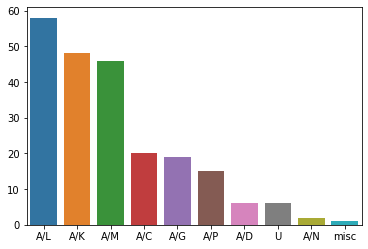

There are 206 examples, with 184 good ones and 22 bad ones.


In [89]:
import seaborn as sns 
from matplotlib import pyplot as plt 
import numpy as np 

# Histogram
num_mistakes_other = 0
num_to_keep = 0
total = 0
# histogram 

histogram_data = []

for line in open('../jimena_work/consolidate_data_1.josnl', 'r'):
    histogram_data.append(json.loads(line))


acceptable = ['A/L', 'A/K', 'A/M', 'A/D', 'A/G', 'A/C', 'A/P', 'A/N', 'misc', 'U']
acceptable_count = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

to_keep = ['A/M', 'A/G', 'A/D', 'A/K', 'A/T', 'A/C', 'A/P', 'A/N', 'A/L']
all_labels = []
for row in data:
    temp = row['ambiguity_type'].strip('"').strip("\\").strip('"').strip(' ')
    labels = temp.split('.')
    for lab in labels:
        if lab == 'A/L':
            acceptable_count[0] += 1
        if lab == 'A/K':
             acceptable_count[1] += 1
        if lab == 'A/M':
             acceptable_count[2] += 1
        if lab == 'A/D':
             acceptable_count[3] += 1
        if lab == 'A/G':
             acceptable_count[4] += 1
        if lab == 'A/C':
             acceptable_count[5] += 1
        if lab == 'A/P':
             acceptable_count[6] += 1
        if lab == 'A/N':
             acceptable_count[7] += 1
        if lab == 'misc':
             acceptable_count[8] += 1
        if lab == 'U':
             acceptable_count[9] += 1
            
        if lab in acceptable:
            all_labels.append(lab)
    total += 1
    for lab in labels:
        if lab in to_keep: 
            num_to_keep += 1 
            break
        else:
            num_mistakes_other  += 1
            break

print(acceptable_count)
df = pd.DataFrame({"Labels": acceptable,
                    "LabelCount": acceptable_count})
g = sns.barplot(x=acceptable, y=acceptable_count, data=df, order=df.sort_values("LabelCount", ascending=False).Labels)

#plt.xticks(rotation=90)
plt.show()

print(f"There are {total} examples, with {num_to_keep} good ones and {num_mistakes_other} bad ones.")

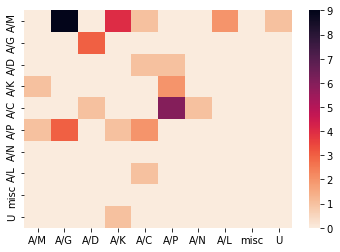

In [44]:
import numpy as np
import pandas as pd
import seaborn  as sns
from matplotlib import pyplot as plt
import json

data_1 = []

for line in open('../jimena_work/consolidate_data_1.josnl', 'r'):
    data_1.append(json.loads(line))

intersection_dict = {'A/M': [0,0,0,0,0,0,0,0,0,0], 
                    'A/G': [0,0,0,0,0,0,0,0,0,0], 
                    'A/D': [0,0,0,0,0,0,0,0,0,0], 
                    'A/K': [0,0,0,0,0,0,0,0,0,0], 
                    'A/C': [0,0,0,0,0,0,0,0,0,0], 
                    'A/P': [0,0,0,0,0,0,0,0,0,0], 
                    'A/N': [0,0,0,0,0,0,0,0,0,0], 
                    'A/L': [0,0,0,0,0,0,0,0,0,0], 
                    'misc': [0,0,0,0,0,0,0,0,0,0], 
                    'U': [0,0,0,0,0,0,0,0,0,0]}
                    
# Heatmap
for row in data_1:
    temp = row['ambiguity_type'].strip('"').strip("\\").strip('"').strip(' ')
    labels = temp.split('.')
    nlabels = len(labels)
    if nlabels > 1:
    
        for lab in range(1, nlabels):
            if labels[lab] == 'A/M':
                intersection_dict[labels[0]][0] = intersection_dict[labels[0]][0] + 1
            if labels[lab] == 'A/G':
                intersection_dict[labels[0]][1] = intersection_dict[labels[0]][1] + 1
            if labels[lab] == 'A/D':
                intersection_dict[labels[0]][2] = intersection_dict[labels[0]][2] + 1
            if labels[lab] == 'A/K':
                intersection_dict[labels[0]][3] = intersection_dict[labels[0]][3] + 1
            if labels[lab] == 'A/C':
                intersection_dict[labels[0]][4] = intersection_dict[labels[0]][4] + 1
            if labels[lab] == 'A/P':
                intersection_dict[labels[0]][5] =intersection_dict[labels[0]][5] + 1
            if labels[lab] == 'A/N':
                intersection_dict[labels[0]][6] = intersection_dict[labels[0]][6] + 1
            if labels[lab] == 'A/L':
                intersection_dict[labels[0]][7] = intersection_dict[labels[0]][7] + 1
            if labels[lab] == 'misc':
                intersection_dict[labels[0]][8] = intersection_dict[labels[0]][8] + 1
            if labels[lab] == 'U':
                intersection_dict[labels[0]][9] = intersection_dict[labels[0]][9] + 1

Yrows = ['A/M', 'A/G', 'A/D', 'A/K', 'A/C', 'A/P', 'A/N', 'A/L', 'misc', 'U']
Xrows = ['A/M', 'A/G', 'A/D', 'A/K', 'A/C', 'A/P', 'A/N', 'A/L', 'misc', 'U']

intersection_2d_array = []
for types in intersection_dict: 
    intersection_2d_array.append(intersection_dict[types])

cmap = sns.cm.rocket_r
ax = sns.heatmap(intersection_2d_array, yticklabels=Yrows, xticklabels = Xrows, cmap=cmap)
#ax.set_yticks(Yrows)
plt.show()

                
        